# Napari Naive Bayes Data Collection Tutorial 

#### Make sure to install the plantcv-annotate add on package 

This tutorial is to collect data for Naive Bayes Machine Learning with plantcv-napari functions instead of ImageJ/FIJI. 

In [1]:
import os

# Detect notebook environment
def detect_notebook_environment():
    if 'COLAB_GPU' in os.environ:
        print('Google Colaboratory detected.')
        %pip install "altair>=5" ipympl plantcv
        
        # Give access and mount your Google Drive (need a Google Account)
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        # Enable widget feature with matplotlib
        from google.colab import output
        output.enable_custom_widget_manager()
        
        #View working directory, may need to change
        %pwd
    else:
        print('Binder detected.')

environment = detect_notebook_environment()

Binder detected.


In [2]:
# If working in Binder, widget may not be functioning
# %matplotlib inline
%gui qt

import numpy as np
import cv2
from plantcv import plantcv as pcv
from plantcv.plantcv import outputs
from plantcv import parallel 
from plantcv.parallel import WorkflowInputs
import plantcv.annotate as pcvan

In [21]:
# Input/output options
args = WorkflowInputs(
    images=["./test-img/testimg.png"],
    names="image",
    result="classified-result.txt",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [4]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

# Collect Training Data Using Napari + PlantCV

### Tile images that you want to use for training, that way data can be collected together. Otherwise you need to append the collected data from separate images together.

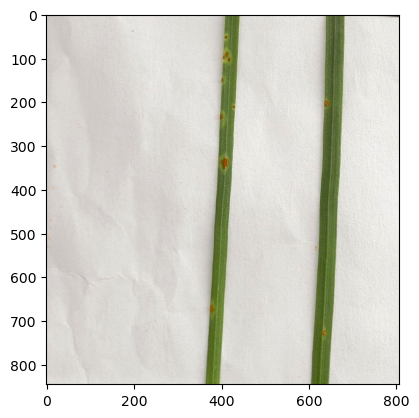

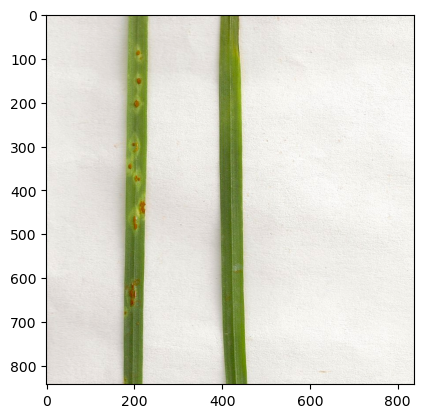

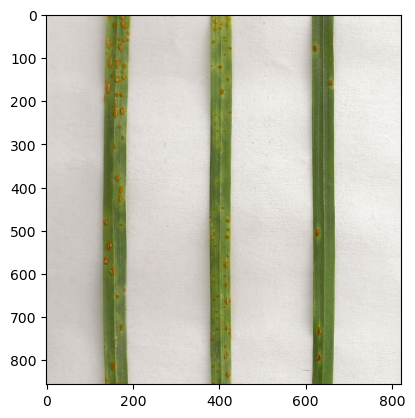

In [5]:
images = []
for i in os.listdir("./img/"):
    images.append(pcv.readimage("./test_images/"+i)[0])

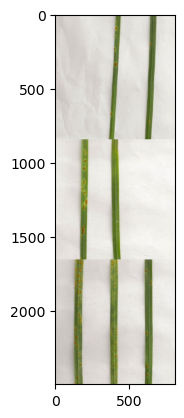

In [6]:
composite = pcv.visualize.tile(images=images, ncol=1)

### These next steps will launch a Napari Viewer. You can collect all new points or if you have previously collected data you can import those points and add new points.

#### These steps are to collect all new points and save them

In [ ]:
#viewer = pcvan.napari_label_classes(composite,['background', 'rust', 'leaf'], size = 6)

#### This step should launch a Napari Viewer (won't work in binder/colab) that looks like this:

![Screenshot](docs/napariviewer.png)

#### Toggle between classes to add points to (green box)
#### Change controls between adding points (+), to removing points (x), to panning the image (purple box). 
#### Zoom in and out with your scroll wheel by placing your mouse in the area you want to zoom.


In [8]:
#datadict = pcvan.napari_save_coor(viewer,"./test-img/naive-bayes-points.txt")

### These steps are to import points and optionally add new ones (if you add new points you should use the save_coor function)

In [7]:
datadict = pcvan.napari_read_coor('./test-img/naive-bayes-points.txt', 'yx')
viewer = pcvan.napari_label_classes(composite,['background', 'rust', 'leaf'],importdata=datadict, size = 6)

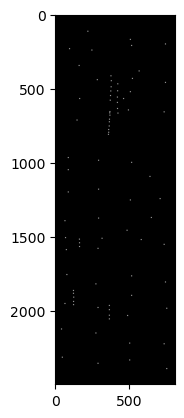

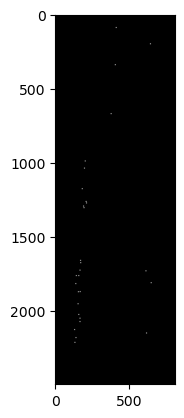

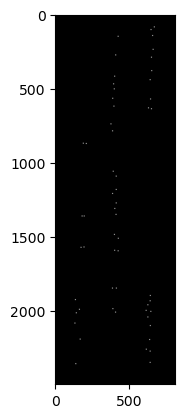

In [9]:
maskdict = pcvan.napari_points_mask(composite,viewer)

In [10]:
data = pcvan.napari_naive_bayes_colors(composite, maskdict,"./test-img/nb-data.txt")
data

,background,rust,leaf
0,"223, 222, 217","141, 158, 66","88, 102, 58"
1,"224, 223, 218","124, 140, 40","84, 99, 55"
2,"224, 223, 218","136, 137, 40","70, 88, 39"
3,"223, 222, 217","111, 90, 0","70, 88, 39"
4,"223, 222, 217","142, 94, 0","93, 110, 63"
...,...,...,...
3091,"232, 231, 226",None,None
3092,"244, 243, 238",None,None
3093,"245, 244, 239",None,None
3094,"231, 230, 225",None,None


# Next Run PlantCV Train

### On the command line run:

```linux

    plantcv-train naive_bayes_multiclass --file ./test-img/nb-data.txt --outfile ./test-img/wheatpdfs.txt

```

### This will result in the pdf files you need to classify images

# Run on a New Test Image Not Used in Training

## This could portion of the workflow could be done in parallel (you wouldn't do the training in parallel)

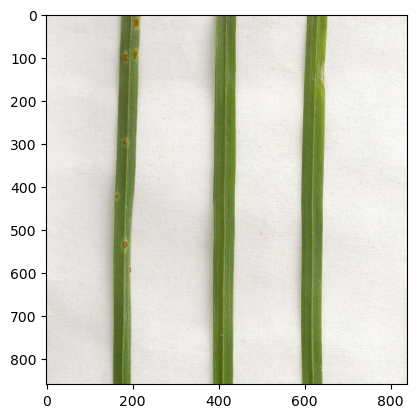

In [11]:
img, path, filename = pcv.readimage(args.image)

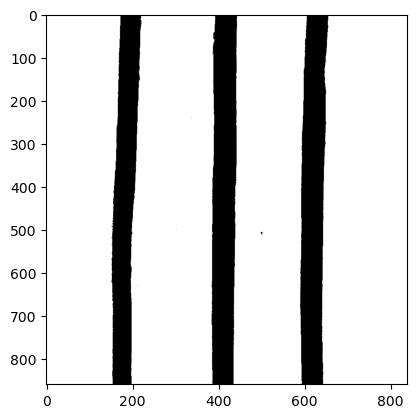

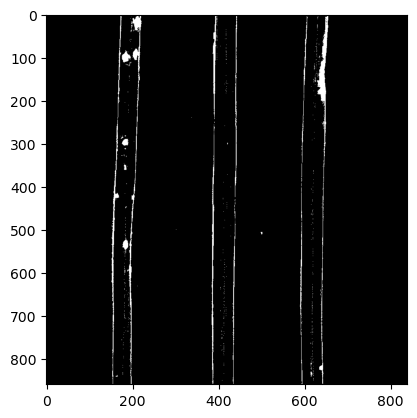

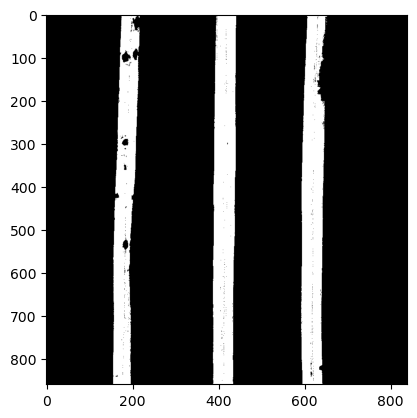

In [12]:
# Use the output file from `plantcv-train.py` to run the multiclass 
# naive bayes classification on the image. The function below will 
# print out 4 masks (plant, pustule, chlorosis, background)

# Inputs: 
#   rgb_img - RGB image data 
#   pdf_file - Output file containing PDFs from `plantcv-train.py`
mask = pcv.naive_bayes_classifier(rgb_img=img, 
                                  pdf_file="./test-img/wheatpdfs.txt")

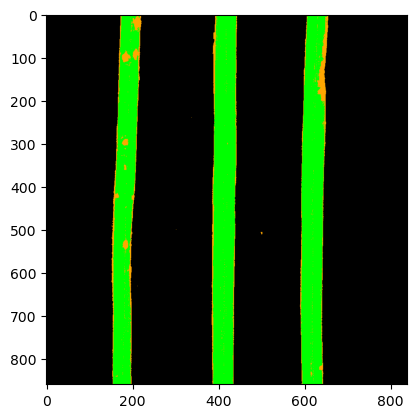

In [28]:
# To see all of these masks together we can plot them with plant set to green,
# chlorosis set to gold, and pustule set to red.

classified_img = pcv.visualize.colorize_masks(masks=[mask['leaf'], mask['rust'],
                                                     mask['background']],
                                              colors=['green', 'orange','black'])


In [18]:
# Calculate percent of the plant found to be diseased 

totalleaf = np.count_nonzero(mask['rust']) + np.count_nonzero(mask['leaf'])
rustarea = np.count_nonzero(mask['rust'])
percent_diseased = rustarea / (totalplant)

In [19]:
# Create a new measurement (gets saved to the outputs class) 

pcv.outputs.add_observation(sample='default', variable='percent_diseased', 
                            trait='percent of plant detected to be diseased',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_diseased, label='percent')

In [20]:
# Data stored to the outputs class can be accessed using the variable name
pcv.outputs.observations['default']['percent_diseased']['value']


0.11900120092955066

In [22]:
# save_results
pcv.outputs.save_results(filename=args.result)

#### To view and/or download the text file output (saved in JSON format)...

 - To see the text file with data that got saved out, click “File” tab in top left corner.
 - Click “Open…”
 - CLick on the file named “ml_tutorial_results.txt”
 - Check out documentation on how to convert JSON format output into table formatted output. 
 - Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits).